# Import Module

In [1]:
import torch
import glob
import warnings 
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader
# from torch.nn.parallel import DistributedDataParallel as DDP

# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 60,
     'BATCH_SIZE' : 64,
     'LR' : 0.00001,
     'Loss_Weights' : torch.Tensor([0.5, 0.3, 0.2]),
     'model_save_path' : f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pneumonia)/model_save_path/color_jitter.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [6]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pneumonia)/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pneumonia)/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [7]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [8]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

# Normal / Virus 데이터가 Bacteria의 절반밖에 안된다 -> augmentation으로 data imbalance를 잡는다
train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

In [9]:
# 이미지 크기: (224,224)로 변환 [훈련/테스트 모두]
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ColorJitter(contrast=0.5),
    torchvision.transforms.ToTensor()
])

aug_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ColorJitter(contrast=0.5),
    torchvision.transforms.ToTensor()
])

# Make Dataset

In [10]:
# Crop Dataset 만들기
# Crop: 이미지에서 불순물 제거 (완전히 제거하지는 못함, 테두리에 낀 불순물만)
class Cropdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.85 * w)  # 가로 길이로는 조금 더 crop 해보기 (쓸데 없는 뼈는 학습하지 않도록)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)  # ndarray 반환
        img = self.__crop__(img)  # PIL Image 반환

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(label)

In [11]:
train_crop_dataset = Cropdataset(train_data, train_label, train_transform)  # t_c_dataset: [IMAGE, LABEL]
train_aug_dataset = Cropdataset(train_aug, train_aug_label, aug_transform)  # t_a_dataset: [IMAGE, LABEL]
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [12]:
img, label = next(iter(train_dataloader))

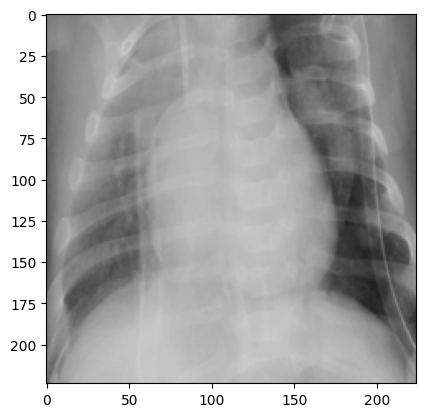

In [13]:
# len(train_dataloader.dataset)  # 7902개의 이미지
from torchvision.transforms.functional import to_pil_image
sample = to_pil_image(img[15])
plt.imshow(sample)

In [14]:
print(f"Image shape : {img[0].shape}")
print(f"Left Image Shape : {label[0].shape}")

Image shape : torch.Size([3, 224, 224])
Left Image Shape : torch.Size([3])


# Define Model

In [15]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x

In [16]:
model = Model().to(device)
model = nn.DataParallel(model).to(device)
model

DataParallel(
  (module): Model(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

# Define Loss, Optimizer

In [17]:
loss_fn = nn.CrossEntropyLoss(CFG['Loss_Weights']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

# Training

In [18]:
def train_loop(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)  # 124 batches in 1 epoch
    datasize = len(dataloader.dataset)  # 7902 images in total

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 30 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()
        scheduler.step()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [19]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, CFG['model_save_path'])

Start epoch : 1
Batch loss : 0.34516 0/124
Batch loss : 0.36397 30/124
Batch loss : 0.36172 60/124
Batch loss : 0.33138 90/124
Batch loss : 0.34576 120/124
Loss : 0.36431 ACC : 41.80%
End epoch : 1
Epoch time : 7.0 min 34.687241077423096 sec

Start epoch : 2
Batch loss : 0.37003 0/124
Batch loss : 0.35121 30/124
Batch loss : 0.34731 60/124
Batch loss : 0.35511 90/124
Batch loss : 0.34289 120/124
Loss : 0.35002 ACC : 35.02%
End epoch : 2
Epoch time : 6.0 min 54.4995014667511 sec

Start epoch : 3
Batch loss : 0.33907 0/124
Batch loss : 0.35510 30/124
Batch loss : 0.32621 60/124
Batch loss : 0.32053 90/124
Batch loss : 0.30501 120/124
Loss : 0.32491 ACC : 34.37%
End epoch : 3
Epoch time : 6.0 min 53.02480101585388 sec

Start epoch : 4
Batch loss : 0.32354 0/124
Batch loss : 0.31354 30/124
Batch loss : 0.31171 60/124
Batch loss : 0.29980 90/124
Batch loss : 0.30350 120/124
Loss : 0.30561 ACC : 35.97%
End epoch : 4
Epoch time : 7.0 min 8.112533569335938 sec

Start epoch : 5
Batch loss : 0.2

Text(0.5, 1.0, 'Train Loss')

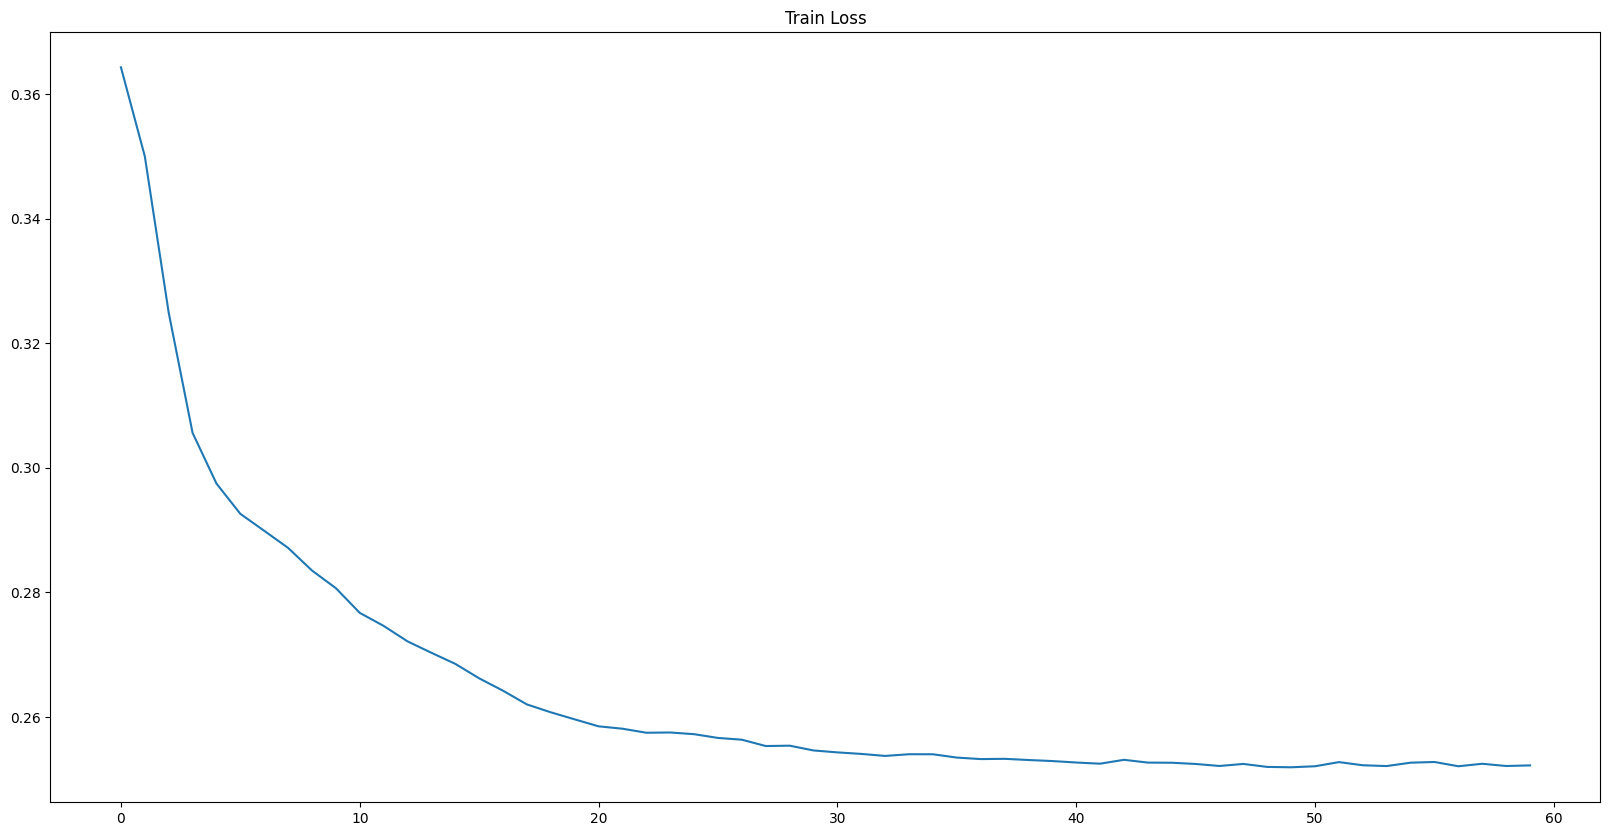

In [20]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

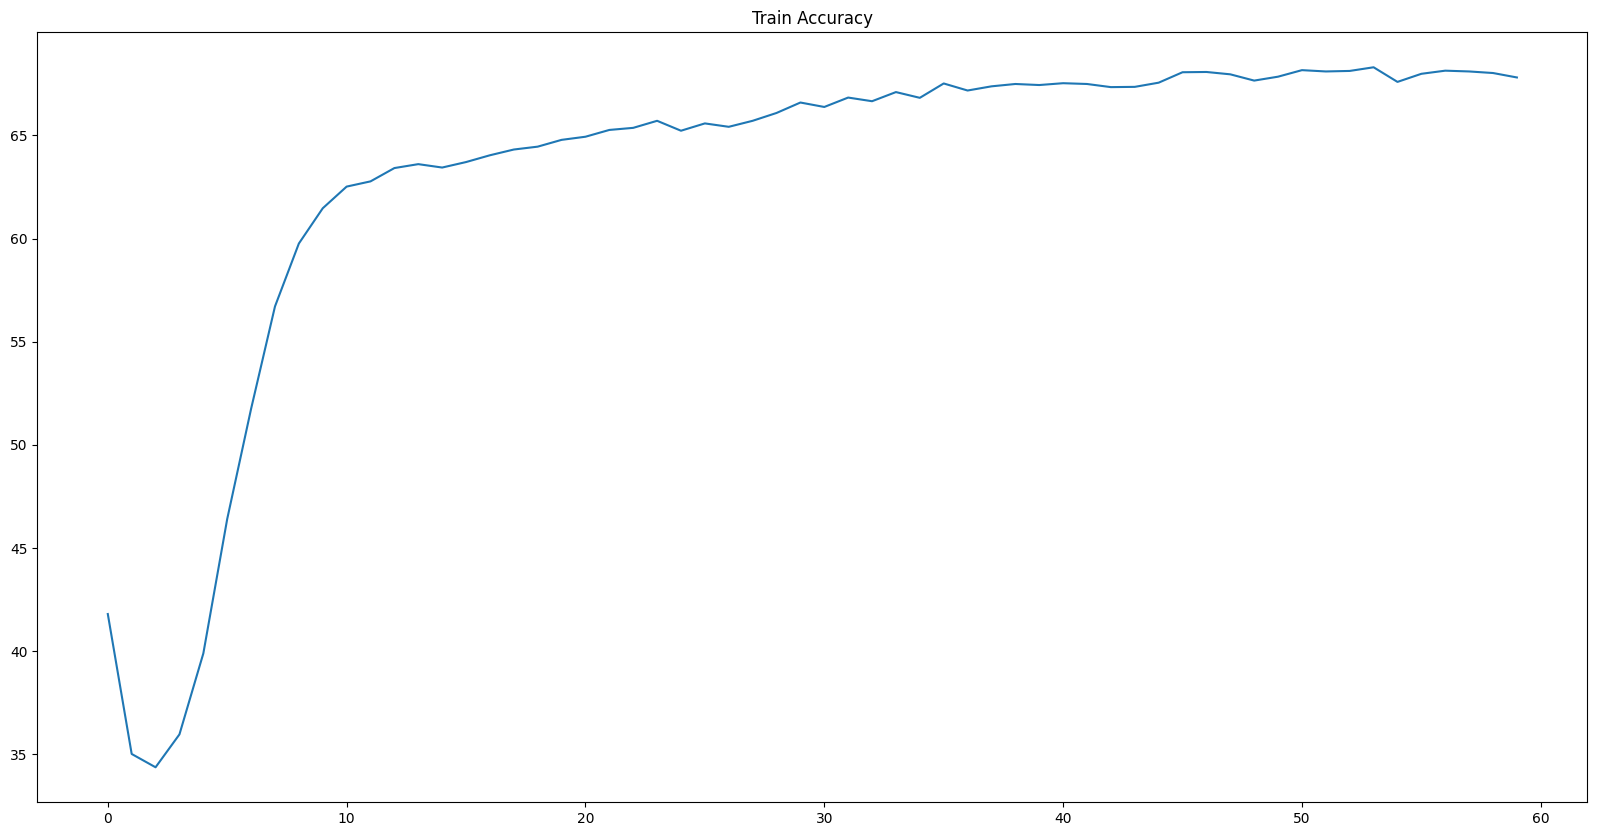

In [21]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')

# TEST

In [22]:
test_crop_dataset = Cropdataset(test_data, test_label, test_transform)  # [IMAGE, LABEL]
test_aug_dataset = Cropdataset(test_vir, test_vir_label, test_transform)  # [IMAGE, LABEL]
test_dataset = test_crop_dataset + test_aug_dataset
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [23]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (X, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output = model(X)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [25]:
label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, label, pred  = test_loop(test_dataloader, model, CFG["model_save_path"])

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

In [28]:
OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

<Axes: >

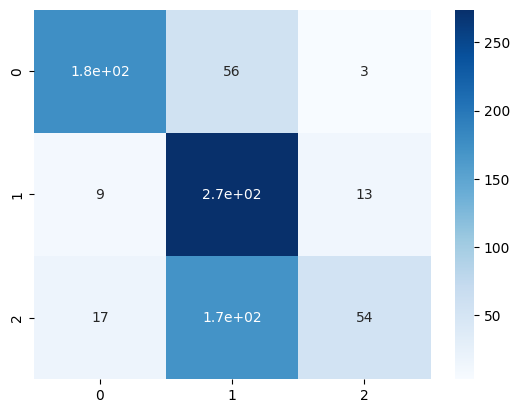

In [29]:
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [30]:
def correct_count(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_correct = 0
    v_correct = 0
    b_correct = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if (pred_idx == label_idx):
            if pred_idx == 0:  # Normal
                n_correct += 1
            elif pred_idx == 1:  # Virus
                v_correct += 1
            elif pred_idx == 2:  # Bacteria
                b_correct += 1
    
    return n_correct, v_correct, b_correct

In [31]:
def nvb_size(label):
    total = len(label)
    total_n = 0
    total_v = 0
    total_b = 0

    for idx in range(total):
        now = label[idx]
        if now[0] == 1:
            total_n += 1
        elif now[1] == 1:
            total_v += 1
        elif now[2] == 1:
            total_b += 1
        
    return total_n, total_v, total_b

In [32]:
total_n, total_v, total_b = nvb_size(label)
n_correct, v_correct, b_correct = correct_count(pred, label)

total = total_n + total_v + total_b
total_correct = n_correct + v_correct + b_correct

print(f"Normal Sensitivity: {n_correct/total_n}")
print(f"Virus Sensitivity: {v_correct/total_v}")
print(f"Bacteria Sensitivity: {b_correct/total_b}\n")
print(f"Test Accuracy: {total_correct/total}")

Normal Sensitivity: 0.7478632478632479
Virus Sensitivity: 0.9256756756756757
Bacteria Sensitivity: 0.2231404958677686

Test Accuracy: 0.6515544041450777
